# FFT Base Model
Purpose:
- deriving a sinusoidal curve from the HR data, and extrapolating the trend to predict the testing set

Notes:
- no downsampling is applied
- uses fast fourier transform from the scipy library

# Imports

In [ ]:
# import libraries
import matplotlib.pyplot as plt
import math
from mpl_toolkits import mplot3d
import numpy as np
import os
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.preprocessing import normalize
from scipy.fft import fft, fftfreq, ifft
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft 

# Loading/Preprocessing

In [ ]:
#Importing the data using an environment variable

csv_folder_path = os.environ.get("CSV_Folder_Path")
file_path = os.path.join(csv_folder_path, "uq_vsd_case04_alldata.csv")


Mounted at /content/drive


In [ ]:
# Filtering the data
df = pd.read_csv(file_path, index_col=False, error_bad_lines=False, usecols=['Time', 'HR', 'SpO2', 'NBP (Mean)', 'ECG'])

df = df.dropna() #drop rows with NaN

case4_filteredData = df.loc[(~df['HR'].isnull()) & (~df['SpO2'].isnull()) & (~df['NBP (Mean)'].isnull()) & (~df['ECG'].isnull())]
case4_filteredData.drop('Time', axis=1, inplace=True)
print(case4_filteredData.head(10))
print(case4_filteredData.tail(10))
print(case4_filteredData.shape)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


         HR  SpO2  NBP (Mean)    ECG
6758  112.0  97.0        93.0 -0.005
6759  112.0  97.0        93.0  0.040
6760  112.0  97.0        93.0  0.080
6761  112.0  97.0        93.0  0.115
6762  112.0  97.0        93.0  0.140
6763  112.0  97.0        93.0  0.140
6764  112.0  97.0        93.0  0.115
6765  112.0  97.0        93.0  0.055
6766  112.0  97.0        93.0  0.000
6767  112.0  97.0        93.0 -0.035
           HR   SpO2  NBP (Mean)    ECG
837315  131.0  100.0        98.0 -0.005
837316  131.0  100.0        98.0 -0.005
837317  131.0  100.0        98.0 -0.005
837318  131.0  100.0        98.0 -0.005
837319  131.0  100.0        98.0 -0.005
837320  131.0  100.0        98.0 -0.005
837321  131.0  100.0        98.0 -0.005
837322  131.0  100.0        98.0 -0.005
837323  131.0  100.0        98.0 -0.005
837324  131.0  100.0        98.0 -0.005
(785853, 4)


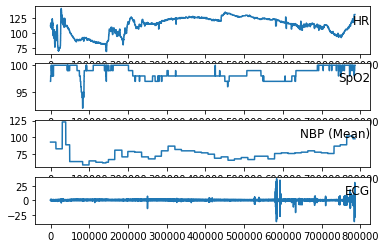

In [ ]:
# plot data
dataset = case4_filteredData # use if google drive
values = dataset.values

# specify columns to plot
groups = [0,1,2,3]
i =1
for g in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, g])
  plt.title(dataset.columns[g], y=0.5, loc='right')
  i += 1
# plt.show()

# FFT Forecasting

In [ ]:
# Prepping the data
raw_var_data = case4_filteredData['HR'] # replace column name with variable you want

# Defining train, test, and axis arrays
ytrain_set = np.array(raw_var_data[0:int(len(raw_var_data)*0.8)])
xtrain_set = np.linspace(1, len(ytrain_set), len(ytrain_set))
ytest_set = np.array(raw_var_data[int(len(raw_var_data)*0.8):])
xtest_set = np.linspace(len(ytrain_set)+1, len(ytrain_set) + len(ytest_set), len(ytest_set))

In [ ]:
# Applying fft
fft_sig = fft(ytrain_set)

# Filtering the fft signal
fft_sig[2:] = 0

# Applying inverse fft
inversed_sig = np.real(ifft(fft_sig))

In [ ]:
# Making "predictions" - extrapolating to test values
K = [0,1]
pred = np.zeros(len(xtest_set))
L = len(xtrain_set)
for n in xtest_set:
    n = int(n)
    for k in xtrain_set[K]:
        k = int(k)
        a = np.real(fft_sig[k-1])
        b = -np.imag(fft_sig[k-1])
        omk = 2 * np.pi * (k-1)/L
        pred[n-L-1] += a * np.cos(omk * (n - 1)) + b * np.sin(omk * (n - 1))

    pred[n-L-1] = pred[n-L-1] / L

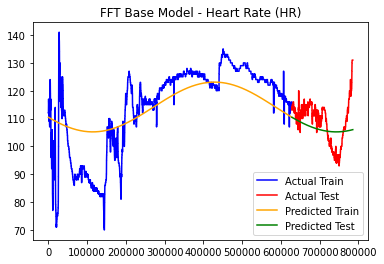

In [ ]:
# Plotting

# Plotting extrapolation
plt.plot(xtrain_set, ytrain_set, 'b', label="Actual Train")
plt.plot(xtest_set, ytest_set, 'r', label="Actual Test")
plt.plot(xtrain_set, inversed_sig, 'orange', label="Predicted Train")
plt.plot(xtest_set, pred, 'green', label="Predicted Test")
plt.title("FFT Base Model - Heart Rate (HR)")
plt.legend()
plt.show()

In [ ]:
print(xtrain_set)
print(xtrain_set.shape)
othertest = np.arange(0, len(raw_var_data))
print(othertest)
print(othertest.shape)

[1.00000e+00 2.00000e+00 3.00000e+00 ... 6.28680e+05 6.28681e+05
 6.28682e+05]
(628682,)
[     0      1      2 ... 785850 785851 785852]
(785853,)


# Extra Code
Commented out but might be useful in the future

In [ ]:
# # Preprocessing/prepping data

# # get column for HR
# hr_filtered_data = case4_filteredData['HR'] # filtered data - HR
# hr_unfiltered_data = old_data['HR']
# # hr_unfiltered_data = hr_unfiltered_data[0:int(len(hr_unfiltered_data)*0.8)] # you don't want it to see the testing set

# sampling_rate = 100
# N = len(hr_unfiltered_data) # number of samples

# # using unfiltered data until you figure out sampling rate
# y = np.array(hr_unfiltered_data)
# x = np.arange(0, len(hr_unfiltered_data))

# # normalize data
# normalized_y = normalize(y[:,np.newaxis], axis=0).ravel()

# # REGULAR FFT
# # apply fft
# yf = fft(normalized_y)
# xf = fftfreq(N, 1/sampling_rate)
# yf[3:] = 0
# inversed_data_fft = ifft(yf)
# print("With FFT:")
# print(f"normalized: {normalized_y.shape}")
# print(f"fft: {yf.shape}")
# print(f"after filter: {yf.shape}")
# print(f"inversed: {inversed_data_fft.shape}\n")

# # RFFT
# # apply rfft
# rffty = rfft(normalized_y)
# rfftx = rfftfreq(N, 1 / sampling_rate)
# rffty[3:] = 0
# inversed_data_rfft = irfft(rffty)
# print("With RFFT")
# print(f"normalized: {normalized_y.shape}")
# print(f"fft: {rffty.shape}")
# print(f"after filter: {rffty.shape}")
# print(f"inversed: {inversed_data_rfft.shape}")

# # plotting
# plt.plot(normalized_y, label="Original", c="pink")
# plt.plot(inversed_data_fft, label="FFT", c="r")
# plt.plot(inversed_data_rfft, label="RFFT", c="m")
# plt.title("HR data")
# plt.legend()
# plt.show()

In [ ]:
# # integration with ciro's prediction code
# # separating train and test sets
# ytrain_set = np.array(hr_unfiltered_data[0:int(len(hr_unfiltered_data)*0.8)])
# xtrain_set = np.linspace(1, len(ytrain_set), len(ytrain_set))
# ytest_set = np.array(hr_unfiltered_data[int(len(hr_unfiltered_data)*0.8):])
# xtest_set = np.linspace(len(ytrain_set)+1, len(ytrain_set) + len(ytest_set), len(ytest_set))

# # apply fft
# new_fft_sig = fft(ytrain_set)

# # filtering
# new_fft_sig[2:] = 0

# # getting back filtered sequence
# filtered_sig = np.real(ifft(new_fft_sig))

# # extrapolating to test values
# K = [0,1]
# pred = np.zeros(len(xtest_set))
# L = len(xtrain_set)
# for n in xtest_set:
#     n = int(n)
#     for k in xtrain_set[K]:
#         k = int(k)
#         a = np.real(new_fft_sig[k-1])
#         b = -np.imag(new_fft_sig[k-1])
#         omk = 2 * np.pi * (k-1)/L
#         pred[n-L-1] += a * np.cos(omk * (n - 1)) + b * np.sin(omk * (n - 1))

#     pred[n-L-1] = pred[n-L-1] / L

# # plotting
# plt.plot(xtrain_set, ytrain_set, 'b', label="Actual Train")
# plt.plot(xtest_set, ytest_set, 'r', label="Actual Test")
# plt.plot(xtrain_set, filtered_sig, 'orange', label="Predicted Train")
# plt.plot(xtest_set, pred, 'green', label="Predicted Test")
# plt.title("FFT Base Model - Heart Rate (HR)")
# plt.legend()
# plt.show()

In [ ]:
# # CLEANING THE SIGNAL

# # 1. getting the difference
# original_signal = normalized_y
# modified_signal = np.copy(original_signal)
# for j in range(5):
#   difference_signal = np.subtract(modified_signal, inversed_data_fft)
#   # sec_diff_sig = abs(np.subtract(modified_signal, difference_signal))

#   # removing noise from diff signal
#   max_val = max(difference_signal)
#   min_val = min(difference_signal)
#   half_val = (max_val - min_val)*0.9

#   for i in range(0, len(difference_signal)):
#     if difference_signal[i] > half_val:
#       modified_signal[i] = inversed_data_fft[i]
  
#   og_yf = fft(modified_signal)
#   og_xf = fftfreq(N, 1/sampling_rate)
#   og_yf[2:] = 0
#   inversed_data_fft = ifft(og_yf)
  
#   plt.plot(inversed_data_fft, label="FFT", c="r")


#   # plotting
#   plt.plot(original_signal, label="Original", c="blue")
#   plt.plot(modified_signal, label="Modified", c="pink")
#   plt.plot(difference_signal, label="Difference", c="m")
#   # plt.plot(sec_diff_sig, label="2nd Difference", linestyle="dotted", c="black")
#   plt.title("HR data")
#   plt.legend()
#   plt.show()